第六章 决策树
>- 与SVM一样， 决策树也是一种多功能的机器学习算法，
>- 它可以现分类和回归任务， 甚至是多输出任务。
>- 它们功能强大， 能够拟合复杂的数据集。
>- 决策树同时也是随机森林的基本组成部分，后者是现今最强大的机器学习算法之一

# 决策树训练和可视化

- 下面的代码在鸢尾花数据集上训练了一个DecisionTreeClassifier：

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [2]:
iris = load_iris()
X = iris['data'][:,2:]
y = iris.target

In [3]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

- 要将决策树可视化，首先，使用export_graphviz（）方法输出一个图形定义文件，命名为iris_tree.dot

In [4]:
from sklearn.tree import export_graphviz
export_graphviz(
    tree_clf,
    out_file='./iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

- 使用graphviz包[1]中的dot命令行工具将这个.dot文件转换为其他格式， 例如PDF或PNG。 
>```
dot -Tpng iris_tree.dot -o iris_tree.png
```

![](iris_tree.png)

# 做出预测

- 节点的samples属性统计它应用的训练实例数量。
- 例如，有100个训练实例的花瓣长度大于2.45厘米（深度1，右），其中54个花瓣宽度小于1.75厘米（深度2，左）。
- 节点的value属性说明了该节点上每个类别的训练实例数量：
- 例如，右下节点应用在0个Setosa鸢尾、1个Versicolor鸢尾和45个Virginica鸢尾实例上。 
- 最后， 节点的gini属性衡量其不纯度（impurity）：
- 如果应用的所有训练实例都属于同一个类别，那么节点就是“纯”的（gini=0）。

## 基尼不纯度
$$ G_i=1-\sum_{k=1}^np_i,k^2 $$

$p_i,k$是第i个节点上，类别为k的训练示例占比

- Scikit-Learn使用的是CART算法，该算法仅生成二叉树：非叶节点永远只有两个子节点（即问题答案仅有是或否）。
- 但是，其他算法，比如ID3生成的决策树，其节点可以拥有两个以上的子节点。

![](img/6-1.png)

- 如你所见，决策树是非常直观的，它们的决策也很容易解释，这类模型通常被称为白盒模型。
- 与之相反的，我们稍后将会看到，随机森林或是神经网络被认为是一种黑盒模型。
- 它们能做出很棒的预测，你也可以轻松检查它们在做出预测时执行的计算，
- 然而，通常很难解释清楚它们为什么做出这样的预测。
- 比如，如果神经网络说某个人出现在一张图片上，很难知道它实际上是基于什么做出的该预测：
- 是模型识别出来了这个人的眼睛？ 嘴巴？ 鼻子？ 还是鞋子？ 甚至是她坐的沙发？
- 相反，决策树提供了简单好用的分类规则，需要的话，你甚至可以手动应用这些规则（例如，花的分类） 

# 估算类别概率

In [4]:
# 预测每种类别的概率
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [5]:
# 直接预测类别
tree_clf.predict([[5, 1.5]])

array([1])

# CART训练算法 

- 首先，使用单个特征k和阈值tk（例如，花瓣长度≤2.45厘米）将训练集分成两个子集。
- k和阈值tk怎么选择？
- 答案是产生出最纯子集（受其大小加权）的k和tk就是经算法搜索确定的（t，tk）。

## CART分类成本函数
$$ J(k,t_k)=\frac{m_{left}}{m}G_{left}+\frac{m_{right}}{m}G_{right} $$
- $G_{left/right}$衡量左/右子集的不纯度
- $m_{left/right}$是左/右子集的实例是数量

- 一旦成功将训练集一分为二，它将使用相同的逻辑，继续分裂子集，然后是子集的子集，
- 依次循环递进。直到抵达最大深度（由超参数max_depth控制），
- 或是再也找不到能够降低不纯度的分裂，它才会停止。 

<small>CART是一种贪婪算法：从顶层开始搜索最优分裂，然后每层重复这个过程。几层分裂之后，它并不会检视这个分裂的不纯度是否为可能的最低值。贪婪算法通常会产生一个相当不错的解，但是不能保证是最优解。</small>

# 计算复杂度

- 进行预测需要从根到叶遍历决策树。
- 通常来说，决策树大致平衡，因此遍历决策树需要经历大约O（log2（m））个节点。（注：log2是以2为底的对数。等于log2（m）=log（m）/log（2）。）
- 而每个节点只需要检查一个特征值，所以总体预测复杂度也只是O（log2（m）） ，与特征数量无关。 - 如此，即便是处理大型数据集，预测也很快。

- 但是，训练时在每一个节点，算法都需要在所有样本上比较所有特征（如果设置了max_features会少一些）。这导致训练的复杂度为O（n×m log（m））。
- 对于小型训练集（几千个实例以内），ScikitLearn可以通过对数据预处理（设置presort=True） 来加快训练，
- 但是对于较大训练集而言， 可能会减慢训练的速度。

# 基尼不纯度还是信息熵

- 默认使用的是基尼不纯度来进行测量，但是，你可以将超参数criterion设置为"entropy"来选择信息熵作为不纯度的测量方式。 
- 如果所有的信息都相同，则熵为零。在机器学习中，它也经常被用作一种不纯度的测量方式：
>如果数据集中仅包含一个类别的实例， 其熵为零。

## 信息熵
$$ H_i=-\sum_{k=1}^np_{i,k}log(p_{i,k}) $$

- 例如上面深度2左侧节点的熵值等于$-\frac{49}{54}log(\frac{49}{54})-\frac{5}{54}log(\frac{5}{54})\approx0.31$

- 大多数情况下，它们并没有什么大的不同，产生的树都很相似。
- 基尼不纯度的计算速度略微快一些，所以它是个不错的默认选择。
- 它们的不同在于，基尼不纯度倾向于从树枝中分裂出最常见的类别，而信息熵则倾向于生产更平衡的树。 

# 正则化超参数

- 决策树极少对训练数据做出假设（比如线性模型就正好相反，它显然假设数据是线性的）。
- 如果不加以限制，树的结构将跟随训练集变化，<mark>严密拟合</mark>，并且很可能<mark>过度拟合</mark>。
- 这种模型通常被称为非参数模型，这不是说它不包含任何参数（事实上它通常有很多参数），而是指在训练之前没有确定参数的数量，导致模型结构自由而紧密地贴近数据。 
- 相应的参数模型，比如线性模型，则有预先设定好的一部分参数，因此其自由度受限，从而降低了过度拟合的风险（但是增加了拟合不足的风险） 。

- 为避免过度拟合， 需要在训练过程中降低决策树的自由度。这个过程被称为正则化。
- 可以限制决策树的最大深度来实现，在Scikit-Learn中，这由超参数max_depth控制
>减小max_depth可使模型正则化， 而降低过度拟合的风险
- DecisionTreeClassifier类还有一些其他的参数，同样可以限制决策树的形状:
- min_samples_split（分裂前节点必须有的最小样本数），
- min_samples_leaf（叶节点必须有的最小样本数量），
- min_weight_fraction_leaf（跟min_samples_leaf一样，但表现为加权实例总数的占比），
- max_leaf_nodes（最大叶节点数量），
- 以及max_features（分裂每个节点评估的最大特征数量）。增大超参数min_*或是减小max_*将使模型正则化

- 下面是在卫星数据集（见第5章介绍） 上训练的两个决策树。 
- 左图使用默认参数（即无约束） 来训练决策树，
- 右图的决策树应用min_samples_leaf=4进行训练。
- 很明显，左图模型过度拟合，右图的泛化效果更佳。
![](img/6-3.png)

# 回归

## 代码示例

In [6]:
# 生成一个带噪声的二次数据集
import numpy as np
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [7]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [16]:
export_graphviz(
    tree_reg,
    out_file='./noise_reg_tree.dot',
    rounded=True,
    filled=True
)

![](noise_reg_tree.png)

- CART算法的工作原理跟前面介绍的大致相同，唯一不同在于，
- 它分裂训练集的方式不是最小化不纯度，而是最小化MSE。 

## CART回归成本函数
$$ J(k,t_k)=\frac{m_{left}}{m}MSE_{left}+\frac{m_{right}}{m}MSE_{right} $$
$$ MSE_{node}=\sum_{i=node}(\hat{y}_{node}-y^{(i)})^2 $$
$$ \hat{y}_{node}=\frac{1}{m_{node}}\sum_{i=node}y^{(i)} $$

In [8]:
import matplotlib.pyplot as plt

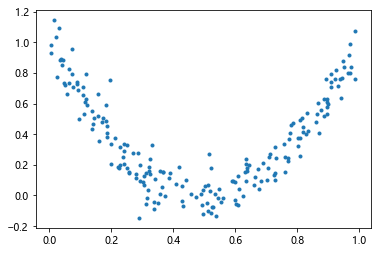

In [10]:
plt.plot(X, y, '.')

- 与分类任务一样， 决策树在处理回归任务时也很容易过度拟合。
- 如果没有任何正则化（即使用默认超参数），
- 你将得到如图左侧所示的预测结果，这显然对训练集严重过度拟合。
- 只需要设置min_samples_leaf=10， 就能得到一个看起来合理得多的模型，

In [13]:
tree_reg_1 = DecisionTreeRegressor()
tree_reg_1.fit(X, y)

tree_reg_2 = DecisionTreeRegressor(min_samples_leaf=10)
tree_reg_2.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Text(0.5, 1.0, 'min_sample_leaf=10')

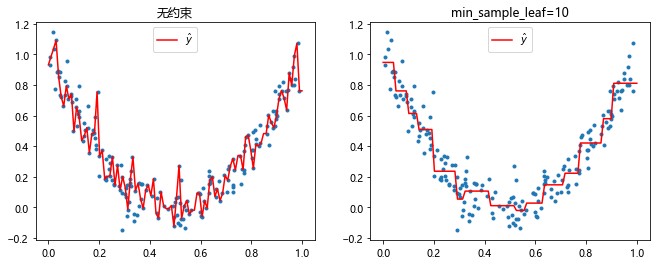

In [14]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(X, y, '.')
X_temp = np.linspace(0, 1, 100).reshape(100, 1)
y_temp = tree_reg_1.predict(X_temp)
plt.plot(X_temp, y_temp, 'r-', label='$\hat{y}$')
plt.legend(loc='upper center')
plt.title('无约束')

plt.subplot(122)
plt.plot(X, y, '.')
X_temp = np.linspace(0, 1, 100).reshape(100, 1)
y_temp = tree_reg_2.predict(X_temp)
plt.plot(X_temp, y_temp, 'r-', label='$\hat{y}$')
plt.legend(loc='upper center')
plt.title('min_sample_leaf=10')

# 不稳定性

- 决策树青睐正交的决策边界（所有的分裂都与轴线垂直），这导致它们对训练集的旋转非常敏感。
- 下面显示了一个简单的线性可分离数据集：
>- 左图里，决策树可以很轻松分裂；
>- 而到了右边，数据集旋转45°后，决策边界产生了不必要的卷曲。
>- 虽然两个模型都看似完美拟合训练集，但是右侧模型很可能泛化不佳。 
>
>![](img/6-7.png)

- 更概括地说， 决策树的主要问题是它们对训练数据中的小变化非常敏感。 
- 例如，如果你从鸢尾花数据集中移除花瓣最宽的Versicolor鸢尾花（花瓣长4.8厘米，宽1.8厘米） ，然后重新训练一个决策树，你可能得到如图6-8所示的模型。 
![](img/6-8.png)